# Import Packages

In [1]:
import numpy as np
import math as math
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Import Functions

In [2]:
import importlib.util
import os

def source_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".py"):
            # Define the module name and path
            module_name = filename[:-3]  # Remove the .py extension
            module_path = os.path.join(directory_path, filename)
            
            # Dynamically load the module
            spec = importlib.util.spec_from_file_location(module_name, module_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            
            # Inject all functions and variables into the global namespace
            globals().update({name: getattr(module, name) for name in dir(module) if not name.startswith("__")})

# Example usage
source_directory("../functions")


In [3]:
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Python/functions/Main")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Python/functions/Prediction")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Python/functions/Selector")

## Input 

In [4]:
### Input ###
N= 15
K = 1
TestProportion = 0.2
Seed = 1
CandidateProportion = 0.8

### Set Up ###
random.seed(Seed)
np.random.seed(Seed)
ErrorVec = []
SelectedObservationHistory = []

### Generate Data ###
df = DataGeneratingProcess(N,K)
df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

In [5]:
def RunLearningProcedure(df_Train, df_Test, df_Candidate, 
                         SelectorType, selector_args,
                         ModelType, model_args):

    ### Set Up ###
    ErrorVec = []
    SelectedObservationHistory = []

    ### Algorithm
    for i in range(0, len(df_Candidate)):

        ### Prediction Model ###
        Model = ModelType(**model_args)
        if "Model" in selector_args.keys(): selector_args['Model'] = Model            # NOTE: THIS IS NOT DYNAMIC

        CurrentError = TestErrorFunction(Model, df_Test)
        ErrorVec.append(CurrentError)

        ### Sampling Procedure ###
        QueryObservationIndex = SelectorType(**selector_args)
        QueryObservation = df_Candidate.loc[[QueryObservationIndex]] # or should this be iloc
        SelectedObservationHistory.append(QueryObservationIndex)

        print("Iteration: ", i, "| QueryIndex: ", QueryObservationIndex, "| Inclusion: ", QueryObservationIndex in df_Candidate.index)
        print(df_Train)
        print(df_Candidate)
        print("---")
        
        ### Update Train and Candidate Sets ###
        df_Train = pd.concat([df_Train, QueryObservation])
        df_Candidate = df_Candidate.drop(QueryObservationIndex)

        ### Update selector_args and model_args ###                                     # NOTE: THIS IS NOT DYNAMIC
        if "df_Train" in model_args.keys(): model_args['df_Train'] = df_Train
        if "df_Train" in selector_args.keys(): selector_args['df_Train'] = df_Train
        if "df_Candidate" in selector_args.keys(): selector_args['df_Candidate'] = df_Candidate            

    return ErrorVec, SelectedObservationHistory

### **Issues**: selector_args

Note that
- PassiveLearning takes input df_Candidate
- GSxFunction takes input df1 and df2
- GSyFunction takes input df1 and df2 and Model
- GSxFunction takes input df1 and df2 and Model

In order to make the overall function RunLearningProcedure dynamic, I inserted selector_args for the different variable inputs for the SelectorType.

However, selector_args does not change with each iteration. As such, df_2/df_Candidate in each selector_args remains the same.

Instead, we can change it manually by adding 

        selector_args['df_Candidate'] = df_Candidate                   # NOTE: THIS IS NOT DYNAMIC 
        model_args['df_Train'] = df_Train                              # NOTE: THIS IS NOT DYNAMIC 

However, this is not dynamic as some SelectorType functions do not have df1/df_Train.

The issue with is similar model_args.

# Active Learning Frameworks

### Random Sampling

In [6]:
ErrorVecPassive, SelectedObservationHistoryPassive = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = PassiveLearning, 
                     selector_args = {'df_Candidate' : df_Candidate},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )

Iteration:  0 | QueryIndex:  13 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
           Y        X1
1  -0.400507  0.720324
12 -0.022260  0.204452
5   0.518809  0.092339
6   0.068658  0.186260
0  -0.925400  0.417022
11 -0.641112  0.685220
9  -1.086348  0.538817
2   0.874642  0.000114
4   0.263862  0.146756
13  1.481721  0.878117
---
Iteration:  1 | QueryIndex:  2 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
13  1.481721  0.878117
           Y        X1
1  -0.400507  0.720324
12 -0.022260  0.204452
5   0.518809  0.092339
6   0.068658  0.186260
0  -0.925400  0.417022
11 -0.641112  0.685220
9  -1.086348  0.538817
2   0.874642  0.000114
4   0.263862  0.146756
---
Iteration:  2 | QueryIndex:  11 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
13  1.481721  0.878117
2   0.874642  0.000114
           Y        X1
1  -0.400507  0.720324
12 -0.022260  0.204452
5   0.518809

### GSx Sampling

In [7]:
ErrorVecGSx, SelectedObservationHistoryGSx = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSxFunction, 
                     selector_args = {'df_Train' : df_Train,
                                      'df_Candidate' : df_Candidate,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )

Iteration:  0 | QueryIndex:  13 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
           Y        X1
1  -0.400507  0.720324
12 -0.022260  0.204452
5   0.518809  0.092339
6   0.068658  0.186260
0  -0.925400  0.417022
11 -0.641112  0.685220
9  -1.086348  0.538817
2   0.874642  0.000114
4   0.263862  0.146756
13  1.481721  0.878117
---
Iteration:  1 | QueryIndex:  2 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
13  1.481721  0.878117
           Y        X1
1  -0.400507  0.720324
12 -0.022260  0.204452
5   0.518809  0.092339
6   0.068658  0.186260
0  -0.925400  0.417022
11 -0.641112  0.685220
9  -1.086348  0.538817
2   0.874642  0.000114
4   0.263862  0.146756
---
Iteration:  2 | QueryIndex:  11 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
13  1.481721  0.878117
2   0.874642  0.000114
           Y        X1
1  -0.400507  0.720324
12 -0.022260  0.204452
5   0.518809

### GSy Sampling (Training Data)

In [8]:
ErrorVecGSy, SelectedObservationHistoryGSy = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )

Line 1 good
Line 2 good
Line 3 good
Line 4 good
Line 5 good
Iteration:  0 | QueryIndex:  12 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
           Y        X1
1  -0.400507  0.720324
12 -0.022260  0.204452
5   0.518809  0.092339
6   0.068658  0.186260
0  -0.925400  0.417022
11 -0.641112  0.685220
9  -1.086348  0.538817
2   0.874642  0.000114
4   0.263862  0.146756
13  1.481721  0.878117
---
Line 1 good
Line 2 good
Line 3 good
Line 4 good
Line 5 good
Iteration:  1 | QueryIndex:  5 | Inclusion:  True
           Y        X1
10 -0.931418  0.419195
7  -0.679614  0.345561
12 -0.022260  0.204452
           Y        X1
1  -0.400507  0.720324
5   0.518809  0.092339
6   0.068658  0.186260
0  -0.925400  0.417022
11 -0.641112  0.685220
9  -1.086348  0.538817
2   0.874642  0.000114
4   0.263862  0.146756
13  1.481721  0.878117
---
Line 1 good
Line 2 good
Line 3 good
Line 4 good
Line 5 good
Iteration:  2 | QueryIndex:  6 | Inclusion:  True
           Y     

IndexError: positional indexers are out-of-bounds

### GSy Sampling (Test Data)

In [ ]:
ErrorVecGSy_Test, SelectedObservationHistoryGSy_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )

### iGS Sampling (Training Data)

In [ ]:
ErrorVeciGS, SelectedObservationHistoryiGS = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )

### iGS Sampling (Test Data)

In [ ]:
ErrorVeciGS_Test, SelectedObservationHistoryiGS_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = LinearRegressionFunction, 
                     model_args = {'df_Train' : df_Train}
                     )

## Results

In [ ]:
pd.DataFrame({"iGSy": SelectedObservationHistoryiGS,
              "iGSy_Test": SelectedObservationHistoryiGS_Test})

,iGSy,iGSy_Test
0,400,894
1,13,400
2,452,13
3,894,452
4,211,211
...,...,...
635,243,243
636,415,415
637,57,57
638,406,406


NameError: name 'ErrorVecGSy_Test' is not defined

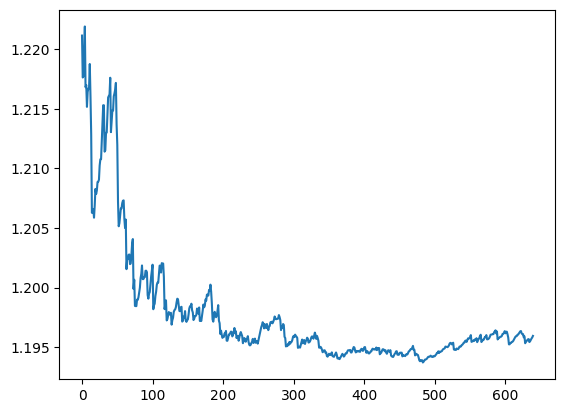

In [ ]:
plt.plot(range(0,len(ErrorVecGSx)), ErrorVecGSx, label = "GSx")
# plt.plot(range(0,len(ErrorVecGSy)), ErrorVecGSy, label = "GSy")
plt.plot(range(0,len(ErrorVecGSy_Test)), ErrorVecGSy_Test, label = "GSy_Test")
# plt.plot(range(0,len(ErrorVeciGS)), ErrorVeciGS, label = "iGS")
plt.plot(range(0,len(ErrorVeciGS_Test)), ErrorVeciGS_Test, label = "iGS_Test")
plt.plot(range(0,len(ErrorVecPassive)), ErrorVecPassive, label = "Random")
plt.legend()
plt.show()


In [ ]:
np.var()

In [ ]:
val = 10
np.var([ErrorVecGSx[-1],
ErrorVecGSy[-1],
ErrorVecGSy_Test[-1],
ErrorVeciGS[-1],
ErrorVeciGS_Test[-1],
ErrorVecPassive[-1]])

NameError: name 'ErrorVecGSy' is not defined